# **Q1. Super-Resolution using Random Fourier Features**

**1.**  Performing super-resolution on the image to enhance its resolution by a factor of 2.

**2.**  Showing a qualitative comparison of the **original** and **reconstructed** images.

In [25]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import os
from PIL import Image
from sklearn.kernel_approximation import RBFSampler
import cv2
import math

# Setting device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Downloading image if not available
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg


dog.jpg exists


In [26]:
# Loading the high-resolution image (original dimensions) using OpenCV
image_path = r'dog.jpg'
if not os.path.exists(image_path):
    print(f"Image at {image_path} does not exist.")
else:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Converting the image to a torch tensor (shape: [H, W, C] -> [C, H, W])
img_tensor = torch.tensor(img).permute(2, 0, 1).float().to(device)
img_tensor.shape

torch.Size([3, 1365, 2048])

In [27]:
# Cropping the high-resolution image to 400x400
crop_size = 400
top, left = 550, 750
img_cropped = torchvision.transforms.functional.crop(img_tensor.cpu(), top, left, crop_size, crop_size)
img_cropped = img_cropped.to(device)

# Converting the tensor back to a NumPy array
img_np = img_cropped.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# Resizing the cropped image using OpenCV to make low-res (200x200)
dim = (200, 200)
low_res_img = cv2.resize(img_np, dim, interpolation=cv2.INTER_LINEAR)

# Converting the low-resolution image to a tensor and normalize it
img_max_val = img_np.max()
img_tensor = torch.tensor(img_np).permute(2, 0, 1).float().to(device) / img_max_val
low_res_tensor = torch.tensor(low_res_img).permute(2, 0, 1).float().to(device)/img_max_val
img_tensor.shape, low_res_tensor.shape

(torch.Size([3, 400, 400]), torch.Size([3, 200, 200]))

In [28]:
# Function to create a 2D grid of coordinates
def create_coordinate_map(height, width):
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    coords = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    return coords

# Creating coordinate maps for both low-res (200x200) and high-res (400x400) images
low_res_coords = create_coordinate_map(200, 200)
high_res_coords = create_coordinate_map(400, 400)

# Scaling coordinates between [-1, 1]
def scale_coordinates(coords):
    return (coords - coords.min()) / (coords.max() - coords.min()) * 2 - 1

low_res_coords_scaled = scale_coordinates(low_res_coords)
high_res_coords_scaled = scale_coordinates(high_res_coords)
low_res_coords_scaled.shape, high_res_coords_scaled.shape

(torch.Size([40000, 2]), torch.Size([160000, 2]))

In [29]:
# Function to create Random Fourier Features (RFF)
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma ** 2), random_state=10)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

# Parameters for RFF
num_rff_features = 50000
sigma = 0.008

# Creating RFF for the low-resolution coordinate map
low_res_coords_rff = create_rff_features(low_res_coords_scaled, num_rff_features, sigma)
low_res_coords_rff.shape

torch.Size([40000, 50000])

In [30]:
# Defining a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

# Initializing the linear regression model
net = LinearRegressionModel(num_rff_features, 3).to(device)

# Training the model using MSE loss
def train_model(net, X, Y, lr=0.005, epochs=1500):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}")

    return net

# Flattening the low-resolution image for training
low_res_Y = low_res_tensor.view(3, 200*200).t().float().to(device)

# Training the model
trained_net = train_model(net, low_res_coords_rff, low_res_Y, lr=0.005, epochs=1500)

Epoch [0/1500], Loss: 0.355573
Epoch [100/1500], Loss: 0.039159
Epoch [200/1500], Loss: 0.005407
Epoch [300/1500], Loss: 0.001673
Epoch [400/1500], Loss: 0.000715
Epoch [500/1500], Loss: 0.000352
Epoch [600/1500], Loss: 0.000205
Epoch [700/1500], Loss: 0.000145
Epoch [800/1500], Loss: 0.000121
Epoch [900/1500], Loss: 0.000112
Epoch [1000/1500], Loss: 0.000109
Epoch [1100/1500], Loss: 0.000107
Epoch [1200/1500], Loss: 0.000106
Epoch [1300/1500], Loss: 0.000106
Epoch [1400/1500], Loss: 0.000105


In [31]:
# Predicting for high-res image
def predict_high_res_image(net, high_res_coords_scaled, num_rff_features, sigma):
    high_res_coords_rff = create_rff_features(high_res_coords_scaled, num_rff_features, sigma)

    with torch.no_grad():
        predicted = net(high_res_coords_rff)
        predicted = predicted.view(400, 400, 3)

    return predicted.permute(2, 0, 1)

# Predicting the high-res image
predicted_high_res = predict_high_res_image(trained_net, high_res_coords_scaled, num_rff_features, sigma)
predicted_high_res.shape

torch.Size([3, 400, 400])

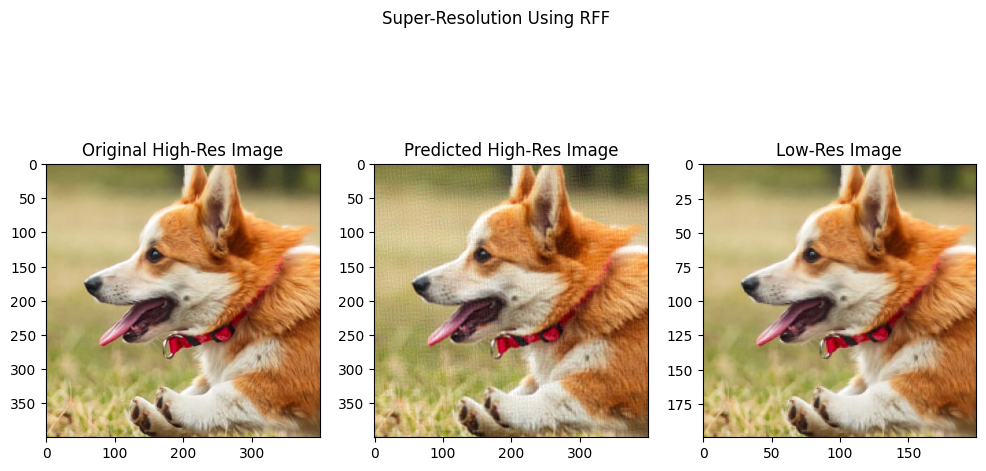

In [32]:
# Plotting the original high-res and predicted images
def plot_images(original, predicted, low_res_tensor, title=""):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    ax[0].imshow(original.permute(1, 2, 0).cpu().numpy().clip(0, 1))
    ax[0].set_title("Original High-Res Image")

    ax[1].imshow(predicted.permute(1, 2, 0).cpu().numpy().clip(0, 1))
    ax[1].set_title("Predicted High-Res Image")

    ax[2].imshow(low_res_tensor.permute(1, 2, 0).cpu().numpy().clip(0, 1))
    ax[2].set_title("Low-Res Image")

    plt.suptitle(title)
    plt.show()

# Plotting the images
plot_images(img_tensor, predicted_high_res, low_res_tensor, title="Super-Resolution Using RFF")

# **Q2. Quantitative Comparison**
**1.**  Calculating RMSE on predicted v/s ground truth high resolution image.

**2.**  Calculating Peak SNR on predicted v/s ground truth high resolution image.

In [33]:
# Function to calculate RMSE and PSNR
def calculate_rmse_psnr(original_img, predicted_img):
    predicted_img = predicted_img.clamp(0, 1)
    original_img = original_img.clamp(0, 1)

    # Calculating RMSE
    rmse = torch.sqrt(F.mse_loss(predicted_img, original_img)).item()

    # Calculating PSNR
    psnr = 20 * math.log10(1.0 / rmse) if rmse != 0 else float('inf')

    return rmse, psnr

# Calculating RMSE and PSNR
rmse, psnr = calculate_rmse_psnr(img_tensor, predicted_high_res)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.4f} dB")

RMSE: 0.0295, PSNR: 30.5909 dB


In [34]:
# Function to calculate Pixel Accuracy
def calculate_pixel_accuracy(original_img, predicted_img, tolerance=0.05):
    original_img = original_img.clamp(0, 1)
    predicted_img = predicted_img.clamp(0, 1)

    # Calculating pixel-wise difference
    pixel_diff = torch.abs(original_img - predicted_img)

    # Counting pixels where the difference is less than the tolerance
    accurate_pixels = (pixel_diff < tolerance).float().mean().item() * 100

    return accurate_pixels

# Calculating Pixel Accuracy
pixel_accuracy = calculate_pixel_accuracy(img_tensor, predicted_high_res)
print(f"Pixel Accuracy: {pixel_accuracy:.2f}%")

Pixel Accuracy: 91.40%
